# Packages

In [3]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import json

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from sklearn.ensemble import RandomForestRegressor
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [4]:
df = (
    pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True)
    .filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))
    .select(pl.all().forward_fill())
)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

In [5]:
df.shape

(26304, 163)

In [6]:
df

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

# Preprocessing

## Missing values

Just forward fill for now.

In [7]:
df = df.fill_null(strategy="forward")

# LASSO

In [40]:
# Splits
frac = 1
df_train = df.filter(pl.col("datetime").dt.year() == 2021).sample(fraction=frac)
df_val = df.filter(pl.col("datetime").dt.year() == 2022).sample(fraction=frac)


X_train = df_train.drop(["datetime", "kWh"])
X_val = df_val.drop(["datetime", "kWh"])


y_train = df_train["kWh"]
y_val = df_val["kWh"]


# Normalising
scaler = StandardScaler()
X_train = pd.DataFrame(
    data=scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()
)


X_val = pd.DataFrame(
    data=scaler.fit_transform(X_val), columns=scaler.get_feature_names_out()
)

In [41]:
alphas = np.linspace(1000, 4000, 15)

val_scores = []
model_coefs = []

for a in tqdm(alphas):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lasso = Lasso(alpha=a)
        lasso = lasso.fit(X_train, y_train)

    # Get the coefficients and determine which features are important
    coef = pd.Series(lasso.coef_, index=X_train.columns)
    model_coefs.append(coef[coef != 0].index.to_list())

    y_pred = lasso.predict(X_val)

    loss = root_mean_squared_error(
        y_pred=y_pred,
        y_true=y_val,
    )
    val_scores.append(loss)

(
    pn.ggplot(
        data=pl.DataFrame({"alpha": alphas, "score": val_scores}),
        mapping=pn.aes("alpha", "score"),
    )
    + pn.geom_line()
)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_coefs[np.argmin(val_scores)]

['Basel_temperature_2m',
 'Basel_relative_humidity_2m',
 'Basel_rain',
 'Basel_snowfall',
 'Basel_snow_depth',
 'Basel_cloud_cover',
 'Basel_wind_speed_10m',
 'Basel_wind_speed_100m',
 'Basel_wind_direction_100m',
 'Basel_wind_gusts_10m',
 'Basel_soil_moisture_28_to_100cm',
 'Bern_relative_humidity_2m',
 'Bern_rain',
 'Bern_snowfall',
 'Bern_wind_speed_10m',
 'Bern_wind_speed_100m',
 'Bern_wind_direction_10m',
 'Bern_wind_gusts_10m',
 'Bern_soil_temperature_7_to_28cm',
 'Bern_soil_moisture_0_to_7cm',
 'Bern_soil_moisture_100_to_255cm',
 'Geneva_temperature_2m',
 'Geneva_relative_humidity_2m',
 'Geneva_dew_point_2m',
 'Geneva_rain',
 'Geneva_snowfall',
 'Geneva_cloud_cover',
 'Geneva_wind_speed_10m',
 'Geneva_wind_speed_100m',
 'Geneva_wind_direction_10m',
 'Geneva_wind_direction_100m',
 'Geneva_wind_gusts_10m',
 'Geneva_soil_moisture_7_to_28cm',
 'Geneva_soil_moisture_100_to_255cm',
 'Lugano_dew_point_2m',
 'Lugano_apparent_temperature',
 'Lugano_precipitation',
 'Lugano_snowfall',
 'L

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_col : Removed 2 rows containing missing values.
matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


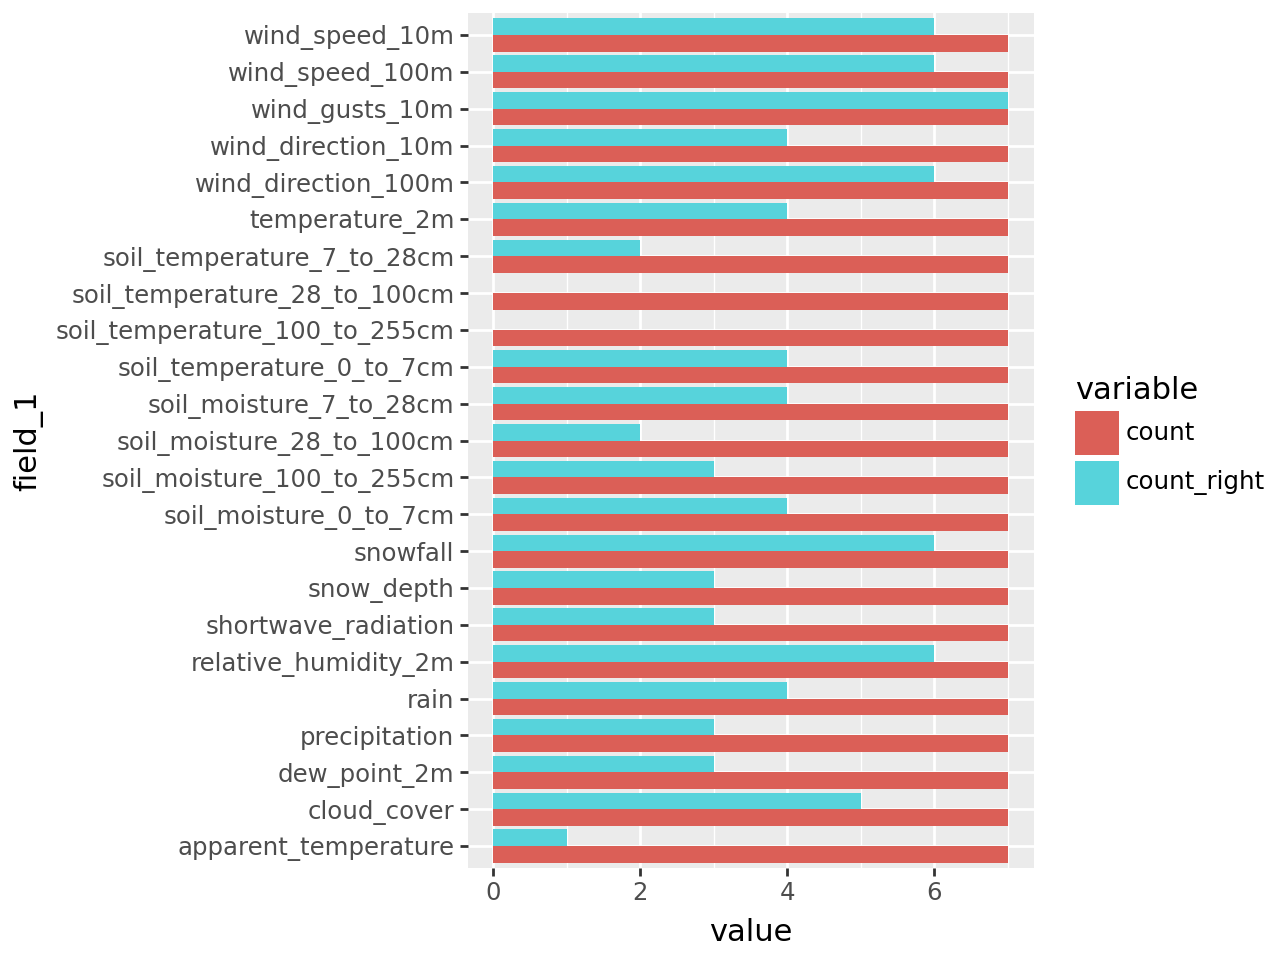

In [ ]:
(
    pn.ggplot(
        data=(
            pl.DataFrame({"name": df.drop(["datetime", "kWh"]).columns})
            .with_columns(pl.col("name").str.splitn("_", 2))
            .unnest("name")["field_1"]
            .value_counts()
            .join(
                (
                    pl.DataFrame({"name": model_coefs[np.argmin(val_scores)]})
                    .with_columns(pl.col("name").str.splitn("_", 2))
                    .unnest("name")["field_1"]
                    .value_counts()
                ),
                how="left",
                on="field_1",
            )
            .unpivot(index="field_1")
        ),
        mapping=pn.aes("field_1", "value", fill="variable"),
    )
    + pn.geom_col(position="dodge")
    + pn.coord_flip()
)

# Random Forest Variable Importance

In [ ]:
# Splitting and sampling as per your setup
frac = 1
df_train = df.filter(pl.col("datetime").dt.year() == 2021).sample(fraction=frac)
df_val = df.filter(pl.col("datetime").dt.year() == 2022).sample(fraction=frac)

X_train = df_train.drop(["datetime", "kWh"]).to_pandas()
X_val = df_val.drop(["datetime", "kWh"]).to_pandas()
y_train = df_train["kWh"].to_pandas()
y_val = df_val["kWh"].to_pandas()

# Normalizing
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()
)
X_val = pd.DataFrame(scaler.transform(X_val), columns=scaler.get_feature_names_out())

In [ ]:
# Random Forest Regressor with default settings
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Getting feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Sorting the features by importance for better visualization
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(
    drop=True
)
importance_df["Feature"] = pd.Categorical(
    importance_df["Feature"], categories=importance_df["Feature"], ordered=True
)

KeyboardInterrupt: 

In [ ]:
importance_df

,Feature,Importance
0,Geneva_soil_temperature_7_to_28cm,0.278451
1,Geneva_shortwave_radiation,0.053830
2,Lugano_shortwave_radiation,0.052917
3,Lugano_soil_temperature_7_to_28cm,0.041649
4,Sion_soil_temperature_7_to_28cm,0.037812
...,...,...
156,Bern_rain,0.000151
157,Zurich_snowfall,0.000116
158,Basel_snowfall,0.000099
159,Geneva_snowfall,0.000097


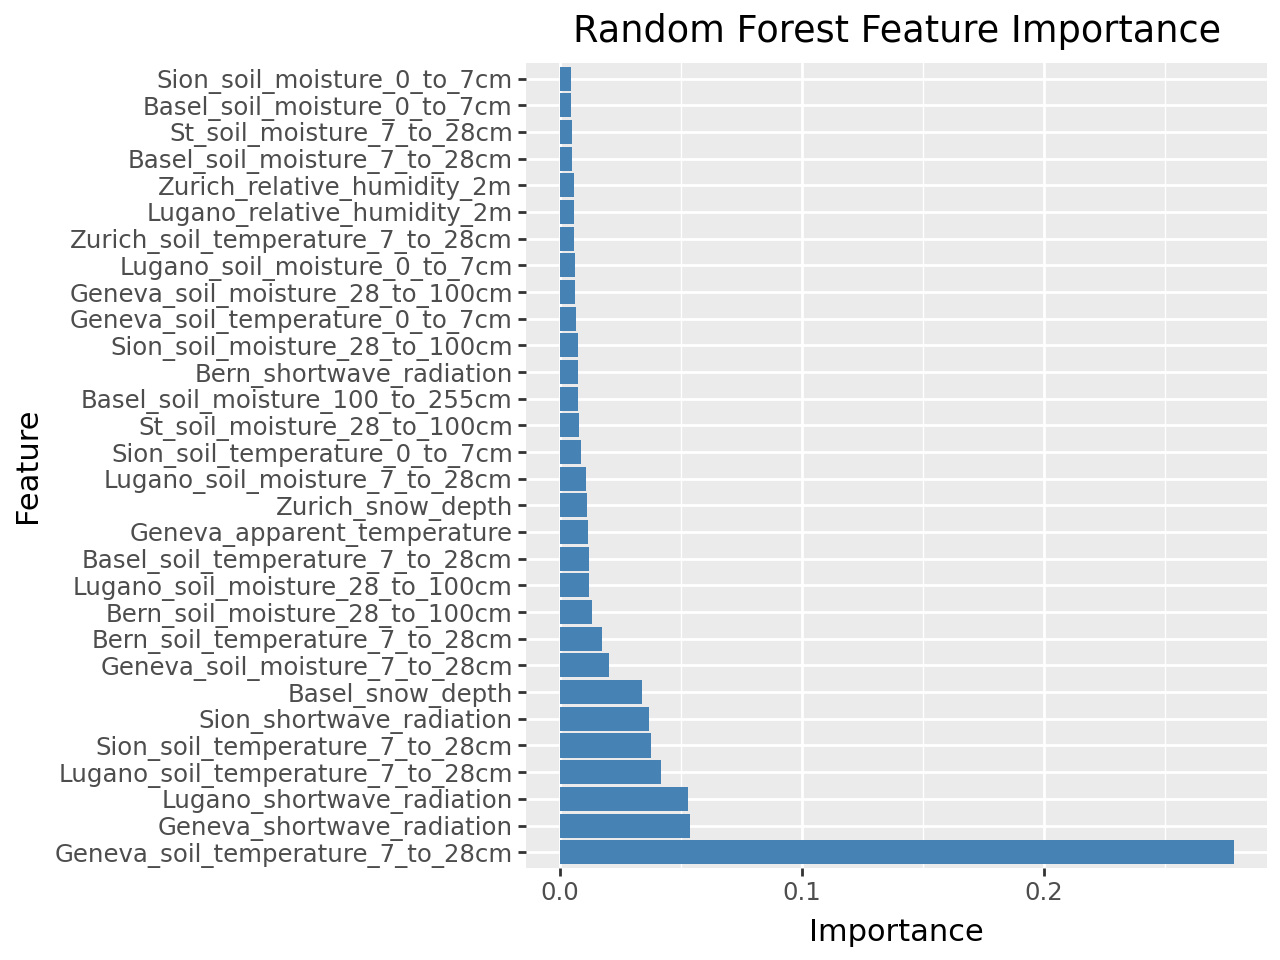

In [ ]:
# Plotting with plotnine
(
    pn.ggplot(importance_df.head(30), pn.aes(x="Feature", y="Importance"))
    + pn.geom_col(fill="steelblue")
    + pn.coord_flip()
    + pn.labs(title="Random Forest Feature Importance", x="Feature", y="Importance")
)

# Simulated Annealing

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
# Splits
df_train = df.filter(
    (pl.col("datetime") >= pl.datetime(2021, 9, 1))
    & (pl.col("datetime") <= pl.datetime(2022, 8, 31))
)
df_val = df.filter(
    (pl.col("datetime") >= pl.datetime(2022, 9, 1))
    & (pl.col("datetime") <= pl.datetime(2023, 8, 31))
)

In [110]:
X_train = df_train.drop(["datetime", "kWh"])
X_val = df_val.drop(["datetime", "kWh"])

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [111]:
def validation_loss(params, X_train):

    # Get selected column numbers
    selected_cols = [i + 1 for i, x in enumerate(params) if x == 1]

    # Select variables
    X_train_selected = X_train.select(pl.nth(selected_cols))
    X_val_selected = X_val.select(pl.nth(selected_cols))

    # Fit model
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_val_selected)
    loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val)

    return loss

In [112]:
def simulated_annealing(config, tune_mode=False):

    params = np.random.choice([0, 1], size=X_train.shape[1])
    params_best = None
    energy_best = None

    for i in (pbar := tqdm(range(config["iterations"]))):

        # Linear temperature decay (easier to scale to larger number of iterations later)
        temperature = (
            config["initial_temp"] - i / config["iterations"] * config["initial_temp"]
        )

        # Generate random neighbour by randomly flipping actions
        params_new = params.copy()
        for _ in range(config["flip_size"]):
            idx = np.random.choice(np.arange(0, len(params)))
            new_options = [x for x in [0, 1] if x != params[idx]]
            params_new[idx] = np.random.choice(new_options)

        # Calculate energy for old and new state
        energy_old = validation_loss(params=params, X_train=X_train)
        energy_new = validation_loss(params=params, X_train=X_train)
        if energy_best is None:
            params_best = params
            energy_best = energy_old

        # Calculate acceptance probability
        # If solution is better than previous accept immediately
        if energy_new < energy_old:
            # Solution is better than previous, but is it better than best
            if energy_new < energy_best:
                params_best = params_new.copy()
                energy_best = energy_new
            params = params_new.copy()
        # If solution isn't better than previous, accept maybe
        else:
            acceptance_prob = np.exp(-(energy_new - energy_old) / (temperature + 1e-8))
            if np.random.uniform() < acceptance_prob:
                params = params_new.copy()

        if tune_mode:
            train.report({"energy": energy_best})
        else:
            pbar.set_description(f"Loss: {energy_best:.2f}")

    if not tune_mode:
        return params_best

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(
        simulated_annealing,
        tune_mode=True,
    ),
    config={
        "iterations": 100,
        "initial_temp": tune.uniform(0.01, 1000),
        "flip_size": tune.randint(1, X_train.shape[1]),
    },
    metric="energy",
    mode="min",
    # local_dir="tune_results",
    name="SA_validation_loss",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60,
    num_samples=-1,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [120]:
analysis.best_config

{'iterations': 100, 'initial_temp': 795.904171035171, 'flip_size': 35}

In [121]:
with open("sa_tuning_params.json", "w") as outfile:
    json.dump(analysis.best_config, outfile)

In [122]:
with open("sa_tuning_params.json") as infile:
    sa_params = json.load(infile)
old_sa_params = sa_params.copy()
old_sa_params

{'iterations': 100, 'initial_temp': 795.904171035171, 'flip_size': 35}

In [126]:
sa_params["iterations"] = 1_000
sa_params["initial_temp"] *= sa_params["iterations"] / old_sa_params["iterations"]

sa_params

{'iterations': 1000, 'initial_temp': 7959041.71035171, 'flip_size': 35}

In [127]:
np.random.seed(42)
params = np.random.choice([0, 1], size=X_train.shape[1])
params_best = None
energy_best = None
best_profits = []
best_solutions = []
all_profits = []


for i in (pbar := tqdm(range(sa_params["iterations"]))):

    # Modify temperature parameters
    # temperature = initial_temp/(i + 1)
    temperature = (
        sa_params["initial_temp"]
        - i / sa_params["iterations"] * sa_params["initial_temp"]
    )

    # Generate random neighbour by randomly flipping actions
    params_new = params.copy()
    for _ in range(sa_params["flip_size"]):
        idx = np.random.choice(np.arange(0, len(params)))
        new_options = [x for x in [0, 1] if x != params[idx]]
        params_new[idx] = np.random.choice(new_options)

    # Calculate energy for old and new state
    energy_old = validation_loss(params=params, X_train=X_train)
    all_profits.append(-energy_old)
    energy_new = validation_loss(params=params_new, X_train=X_train)
    if energy_best is None:
        params_best = params
        energy_best = energy_old

    # Calculate acceptance probability
    # If solution is better than previous accept immediately
    if energy_new < energy_old:
        # Solution is better than previous, but is it better than best
        if energy_new < energy_best:
            params_best = params_new.copy()
            energy_best = energy_new
        params = params_new.copy()
    # If solution isn't better than previous, accept maybe
    else:
        acceptance_prob = np.exp(-(energy_new - energy_old) / (temperature + 1e-8))
        if np.random.uniform() < acceptance_prob:
            params = params_new.copy()

    # Save interim results
    best_solutions.append(params_best)
    best_profits.append(-energy_best)

    pbar.set_description(f"Profit: {energy_best:,.0f} Temperature: {temperature:,.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [132]:
best_cols = [i + 1 for i, x in enumerate(params_best) if x == 1]

# Select variables
X_train.select(pl.nth(best_cols))

Basel_relative_humidity_2m,Basel_apparent_temperature,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_apparent_temperature,Bern_rain,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_soil_temperature_7_to_28cm,Bern_soil_moisture_7_to_28cm,Bern_soil_moisture_28_to_100cm,Geneva_temperature_2m,Geneva_relative_humidity_2m,Geneva_snowfall,Geneva_snow_depth,Geneva_wind_speed_10m,Geneva_wind_speed_100m,Geneva_wind_direction_100m,Geneva_wind_gusts_10m,Geneva_soil_temperature_7_to_28cm,Geneva_soil_temperature_28_to_100cm,Geneva_soil_moisture_7_to_28cm,Geneva_soil_moisture_100_to_255cm,Lugano_relative_humidity_2m,…,Lugano_wind_speed_100m,Lugano_wind_direction_10m,Lugano_wind_gusts_10m,Lugano_soil_moisture_28_to_100cm,Lugano_soil_moisture_100_to_255cm,Lugano_shortwave_radiation,Sion_relative_humidity_2m,Sion_apparent_temperature,Sion_snow_depth,Sion_cloud_cover,Sion_wind_speed_10m,Sion_wind_direction_100m,Sion_wind_gusts_10m,Sion_soil_temperature_0_to_7cm,Sion_soil_temperature_7_to_28cm,St_temperature_2m,St_relative_humidity_2m,St_dew_point_2m,St_apparent_temperature,St_rain,St_snowfall,St_wind_speed_10m,St_wind_gusts_10m,St_soil_temperature_28_to_100cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_snowfall,Zurich_cloud_cover,Zurich_wind_speed_100m,Zurich_wind_direction_100m,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
86.62722,14.274088,0.0,23.1,8.0899935,10.440001,15.377,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.801474,0.0,1.5,7.9036193,20.140705,15.1945,0.331,0.36,14.964001,80.11441,0.0,0.0,12.397806,26.925497,29.649773,28.44,18.264,17.814001,0.239,0.356,64.97063,…,4.32,50.194473,10.799999,0.332,0.404,0.0,91.475525,12.124262,0.0,15.3,4.1046314,57.99466,20.880001,15.398001,17.898,12.8445,82.81585,9.994499,12.375185,0.0,0.0,3.319036,13.32,14.294499,0.416,0.423,13.192,88.84562,0.0,4.2000003,20.111729,45.72514,15.642,0.382,0.359,0.394,0.0
91.223816,13.115568,0.0,10.800001,5.6233797,7.5599995,14.776999,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.245484,0.0,0.9,7.491114,19.770523,15.0945,0.331,0.36,14.314,83.26969,0.0,0.0,9.021574,22.782625,31.429514,27.0,18.164,17.814001,0.239,0.356,64.50534,…,6.439876,16.699326,11.159999,0.332,0.404,0.0,90.250565,11.854042,0.0,25.8,3.319036,52.124958,21.24,14.898001,17.698,10.744499,93.54089,9.744499,9.759705,0.0,0.0,6.3690495,16.56,14.294499,0.414,0.422,12.642,92.40392,0.0,0.6,23.233252,40.601215,15.642,0.381,0.359,0.394,0.0
88.56768,13.566463,0.0,6.6000004,6.830519,6.8399997,14.627,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,10.04735,0.0,3.9,9.339208,21.578989,15.044499,0.332,0.36,12.964001,88.23973,0.0,0.0,9.585739,18.39878,30.579157,20.519999,18.164,17.814001,0.236,0.356,67.78884,…,2.16,63.435013,11.52,0.333,0.404,0.0,91.08589,10.493567,0.0,10.5,3.671294,44.999897,20.880001,15.198,17.448,12.1945,93.61181,11.1945,11.977064,0.0,0.0,4.0249224,16.56,14.294499,0.409,0.419,12.592,92.707214,0.0,1.8000001,23.469128,48.731503,15.642,0.378,0.358,0.394,0.0
89.72258,13.146872,0.0,0.6,2.7416782,5.04,14.026999,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.884285,0.0,8.099999,9.085988,20.140705,14.9445,0.332,0.36,13.164001,86.231735,0

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_col : Removed 1 rows containing missing values.
matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


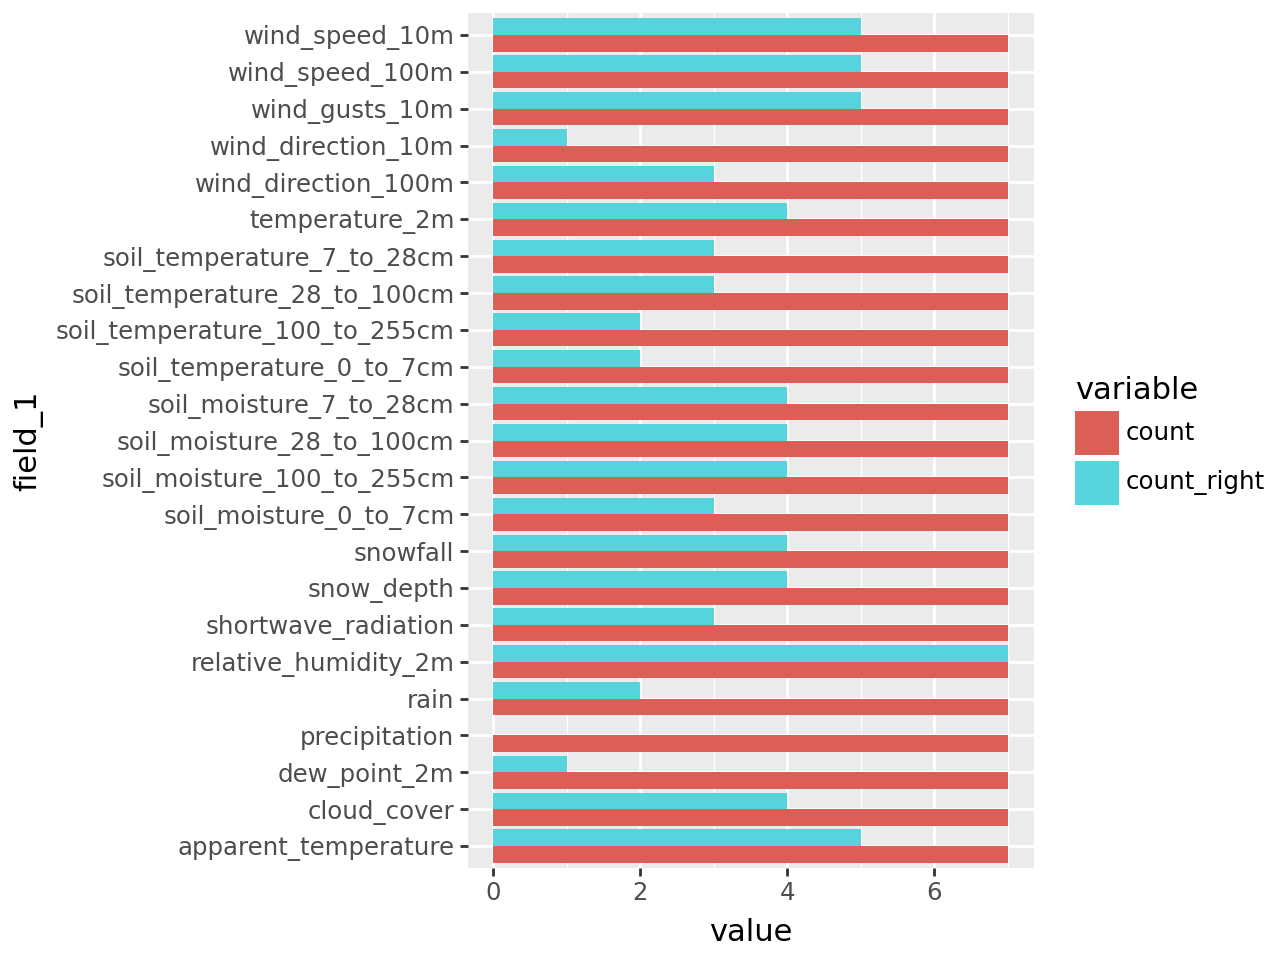

In [133]:
(
    pn.ggplot(
        data=(
            pl.DataFrame({"name": df.drop(["datetime", "kWh"]).columns})
            .with_columns(pl.col("name").str.splitn("_", 2))
            .unnest("name")["field_1"]
            .value_counts()
            .join(
                (
                    pl.DataFrame({"name": X_train.select(pl.nth(best_cols)).columns})
                    .with_columns(pl.col("name").str.splitn("_", 2))
                    .unnest("name")["field_1"]
                    .value_counts()
                ),
                how="left",
                on="field_1",
            )
            .unpivot(index="field_1")
        ),
        mapping=pn.aes("field_1", "value", fill="variable"),
    )
    + pn.geom_col(position="dodge")
    + pn.coord_flip()
)

# Reduce Features to Temperature

In [8]:
df = (
    pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True)
    .filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))
    .select(pl.all().forward_fill())
)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

In [ ]:
(
    df.select(
        "datetime",
        "kWh",
        "Zurich_shortwave_radiation",
        "Zurich_soil_temperature_7_to_28cm",
    )
    .to_pandas()
    .to_csv("../0_data/preprocessed/df_final_reduced.csv", index=False)
)